In [1]:
import os
import torch
import torch.nn as nn
from einops import rearrange
# import imageio.v3 as iio
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import torch.nn.functional as F
import warnings
from video_dataset import VideoFrameDataset, ImglistToTensor

/Users/GIacomoBugli/opt/anaconda3/envs/cds_dl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00


In [3]:
root = '/Users/luiginoto/Downloads/Dataset_Student/unlabeled/data/'
annotation_file = '/Users/luiginoto/Downloads/Dataset_Student/unlabeled/annotations.txt'

In [8]:
root = '../Dataset/Dataset_Student/train/data/'
annotation_file = '../Dataset/Dataset_Student/train/annotations.txt'

In [9]:
# transform_train = transforms.Compose([
#     #transforms.RandomCrop(32, padding=4),
#     transforms.Resize((128,128)),
#     #transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        # transforms.Resize(299),  # image batch, resize smaller edge to 299
        transforms.Resize((128,128)),
        # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [10]:
dataset = VideoFrameDataset(
    root_path=root,
    annotationfile_path=annotation_file,
    num_segments=1,
    frames_per_segment=22,
    imagefile_template='image_{:d}.png',
    transform=preprocess,
    mask=True,
    test_mode=False
)

In [11]:
sample = dataset[0] 
frames = sample[0]

In [14]:
len(sample)

3

In [17]:
mask = sample[2]
mask.shape

torch.Size([22, 160, 240])

In [11]:
frames.shape

torch.Size([22, 3, 128, 128])

/var/folders/hg/jndwjz217312f4zs_42h9q040000gp/T/ipykernel_64611/1220864285.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  plt.imshow(torch.transpose(frames[0],1,2).T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


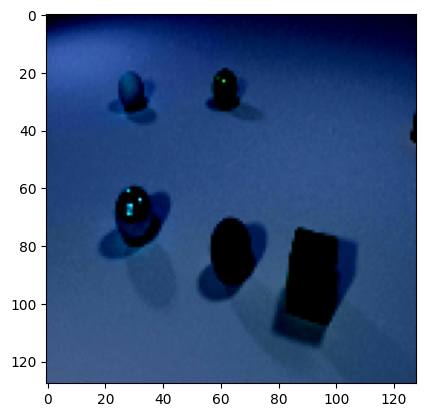

In [16]:
import matplotlib.pyplot as plt
plt.imshow(torch.transpose(frames[0],1,2).T)

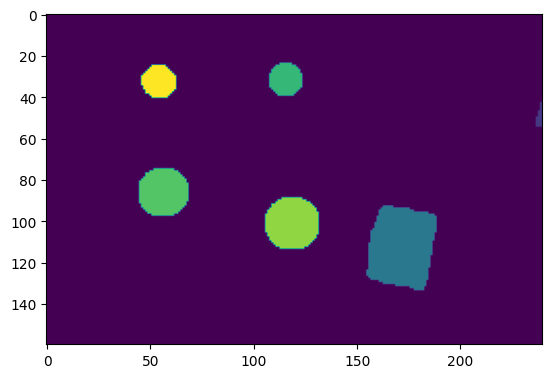

In [20]:
plt.imshow(mask[0])

In [13]:
dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=2,
        shuffle=True,
        num_workers=1,
        pin_memory=True
    )

In [14]:
dataloader

In [15]:
data, target = next(iter(dataloader))

In [16]:
data.shape

torch.Size([2, 22, 3, 128, 128])

In [17]:
def _ntuple(n):
    def parse(x):
        if isinstance(x, container_abcs.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse
to_2tuple = _ntuple(2)

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor
    
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = img_size, img_size
        patch_size = patch_size, patch_size
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, T, H, W = x.shape
        x = rearrange(x, 'b c t h w -> (b t) c h w')
        x = self.proj(x)
        W = x.size(-1) #W? 
        print(x.shape)
        x = x.flatten(2).transpose(1, 2)
        return x, T, W

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., with_qkv=True):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.with_qkv = with_qkv
        if self.with_qkv:
           self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
           self.proj = nn.Linear(dim, dim)
           self.proj_drop = nn.Dropout(proj_drop)
        self.attn_drop = nn.Dropout(attn_drop)

    def forward(self, x):
        B, N, C = x.shape
        if self.with_qkv:
           qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
           q, k, v = qkv[0], qkv[1], qkv[2]
        else:
           qkv = x.reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
           q, k, v  = qkv, qkv, qkv

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        if self.with_qkv:
           x = self.proj(x)
           x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0.1, act_layer=nn.GELU, norm_layer=nn.LayerNorm, attention_type='divided_space_time'):
        super().__init__()
        self.attention_type = attention_type
        assert(attention_type in ['divided_space_time', 'space_only','joint_space_time'])

        self.norm1 = norm_layer(dim)
        self.attn = Attention(
           dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        ## Temporal Attention Parameters
        if self.attention_type == 'divided_space_time':
            self.temporal_norm1 = norm_layer(dim)
            self.temporal_attn = Attention(
              dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
            self.temporal_fc = nn.Linear(dim, dim)

        ## drop path
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)


    def forward(self, x, B, T, W):
        num_spatial_tokens = (x.size(1) - 1) // T
        H = num_spatial_tokens // W

        if self.attention_type in ['space_only', 'joint_space_time']:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x
        elif self.attention_type == 'divided_space_time':
            ## Temporal
            xt = x # xt = x[:,1:,:]
            xt = rearrange(xt, 'b (h w t) m -> (b h w) t m',b=B,w=W,t=T)
            res_temporal = self.drop_path(self.temporal_attn(self.temporal_norm1(xt)))
            res_temporal = rearrange(res_temporal, '(b h w) t m -> b (h w t) m',b=B,w=W,t=T)
            res_temporal = self.temporal_fc(res_temporal)
            xt = x + res_temporal # xt = x[:,1:,:] + res_temporal

            ## Spatial
            # init_cls_token = x[:,0,:].unsqueeze(1)
            # cls_token = init_cls_token.repeat(1, T, 1)
            # cls_token = rearrange(cls_token, 'b t m -> (b t) m',b=B,t=T).unsqueeze(1)
            xs = xt
            xs = rearrange(xs, 'b (h w t) m -> (b t) (h w) m',b=B,w=W,t=T)
            # xs = torch.cat((cls_token, xs), 1)
            res_spatial = self.drop_path(self.attn(self.norm1(xs)))

            ### Taking care of CLS token
            # cls_token = res_spatial[:,0,:]
            # cls_token = rearrange(cls_token, '(b t) m -> b t m',b=B,t=T)
            # cls_token = torch.mean(cls_token,1,True) ## averaging for every frame
            # res_spatial = res_spatial[:,1:,:]
            res_spatial = rearrange(res_spatial, '(b t) (h w) m -> b (h w t) m',b=B,w=W,t=T)
            res = res_spatial
            x = xt

            ## Mlp
            x = x + res # x = torch.cat((init_cls_token, x), 1) + torch.cat((cls_token, res), 1)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

In [18]:
class VisionTransformer(nn.Module):
    """ Vision Transformer
    """
    # def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
    #              num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
    #              drop_path_rate=0.1, hybrid_backbone=None, norm_layer=nn.LayerNorm, num_frames=8, attention_type='divided_space_time', dropout=0.):
    def __init__(self, embed_dim=768, depth=12,
                    num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                  drop_path_rate=0.1, hybrid_backbone=None, norm_layer=nn.LayerNorm, num_frames=8, attention_type='divided_space_time', dropout=0.):
        super().__init__()
        self.attention_type = attention_type
        self.depth = depth
        self.dropout = nn.Dropout(dropout)
        # self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        # self.patch_embed = PatchEmbed(
        #     img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        # num_patches = self.patch_embed.num_patches

        ## Positional Embeddings
        # self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))
        # self.pos_drop = nn.Dropout(p=drop_rate)
        # if self.attention_type != 'space_only':
        #     self.time_embed = nn.Parameter(torch.zeros(1, num_frames, embed_dim))
        #     self.time_drop = nn.Dropout(p=drop_rate)

        ## Attention Blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, self.depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, attention_type=self.attention_type)
            for i in range(self.depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        # self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        # trunc_normal_(self.pos_embed, std=.02)
        # trunc_normal_(self.cls_token, std=.02)
        # self.apply(self._init_weights)

        ## initialization of temporal attention weights
        if self.attention_type == 'divided_space_time':
            i = 0
            for m in self.blocks.modules():
                m_str = str(m)
                if 'Block' in m_str:
                    if i > 0:
                      nn.init.constant_(m.temporal_fc.weight, 0)
                      nn.init.constant_(m.temporal_fc.bias, 0)
                    i += 1

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    # @torch.jit.ignore
    # def no_weight_decay(self):
    #     return {'pos_embed', 'cls_token', 'time_embed'}

    # def get_classifier(self):
    #     return self.head

    # def reset_classifier(self, num_classes, global_pool=''):
    #     self.num_classes = num_classes
    #     self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x, B, T, W):
        # B = x.shape[0]
        # x, T, W = self.patch_embed(x)
        # cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        # x = torch.cat((cls_tokens, x), dim=1)

        # ## resizing the positional embeddings in case they don't match the input at inference
        # if x.size(1) != self.pos_embed.size(1):
        #     pos_embed = self.pos_embed
        #     cls_pos_embed = pos_embed[0,0,:].unsqueeze(0).unsqueeze(1)
        #     other_pos_embed = pos_embed[0,1:,:].unsqueeze(0).transpose(1, 2)
        #     P = int(other_pos_embed.size(2) ** 0.5)
        #     H = x.size(1) // W
        #     other_pos_embed = other_pos_embed.reshape(1, x.size(2), P, P)
        #     new_pos_embed = F.interpolate(other_pos_embed, size=(H, W), mode='nearest')
        #     new_pos_embed = new_pos_embed.flatten(2)
        #     new_pos_embed = new_pos_embed.transpose(1, 2)
        #     new_pos_embed = torch.cat((cls_pos_embed, new_pos_embed), 1)
        #     x = x + new_pos_embed
        # else:
        #     x = x + self.pos_embed
        # x = self.pos_drop(x)


        # ## Time Embeddings
        # if self.attention_type != 'space_only':
        #     cls_tokens = x[:B, 0, :].unsqueeze(1)
        #     x = x[:,1:]
        #     x = rearrange(x, '(b t) n m -> (b n) t m',b=B,t=T)
        #     ## Resizing time embeddings in case they don't match
        #     if T != self.time_embed.size(1):
        #         time_embed = self.time_embed.transpose(1, 2)
        #         new_time_embed = F.interpolate(time_embed, size=(T), mode='nearest')
        #         new_time_embed = new_time_embed.transpose(1, 2)
        #         x = x + new_time_embed
        #     else:
        #         x = x + self.time_embed
        #     x = self.time_drop(x)
        #     x = rearrange(x, '(b n) t m -> b (n t) m',b=B,t=T)
        #     x = torch.cat((cls_tokens, x), dim=1)

        ## Attention blocks
        for blk in self.blocks:
            x = blk(x, B, T, W)

        ### Predictions for space-only baseline
        if self.attention_type == 'space_only':
            x = rearrange(x, '(b t) n m -> b t n m',b=B,t=T)
            x = torch.mean(x, 1) # averaging predictions for every frame

        x = self.norm(x)
        
        # return x[:, 0]
        # change shape 'b (h w t) m -> b t (h w) m'
        x = rearrange(x, 'b (h w t) m -> b t (h w) m',b=B,t=T,w=W)
        return x

    # def forward(self, x, B, T, W):
    #     x = self.forward_features(x)
    #     # x = self.head(x)
    #     return x

- Get patch embed for each frame of video
- Split into context and target with: context first 11 frames, target all frames (or context first frame oatches + random subsequent patches)
- Add learnable spatial-temporal positional embedding
- Feed context and target into context encoder and target encoder
- Input 11 mask token and context representation to predictor (ViT)
- 

In [28]:
class IJEPA_base(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, enc_depth=12, pred_depth=12, num_heads=12,
                  mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0.1, hybrid_backbone=None, norm_layer=nn.LayerNorm, num_frames=22, attention_type='divided_space_time', dropout=0.,
                 mode="train", M=4):
        super().__init__()
        self.mode = mode
        self.dropout = dropout
        self.mask_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        nn.init.trunc_normal_(self.mask_token, 0.02)
        self.M = M # number of masked frames
        ####

        self.norm_layer = norm_layer
        self.norm = norm_layer(embed_dim)

        self.attention_type = attention_type

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim)) # self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        if self.attention_type != 'space_only':
            self.time_embed = nn.Parameter(torch.zeros(1, num_frames, embed_dim))
            self.time_drop = nn.Dropout(p=drop_rate)

        self.teacher_encoder = VisionTransformer(
            embed_dim=embed_dim,
            num_heads=num_heads,
            depth=enc_depth, 
            dropout=self.dropout,
            norm_layer=self.norm_layer
        )

        self.student_encoder = copy.deepcopy(self.teacher_encoder).cpu()
        self.predictor = VisionTransformer(
            embed_dim=embed_dim,
            num_heads=num_heads,
            depth=enc_depth, 
            dropout=self.dropout,
            norm_layer=self.norm_layer
        )
        

    @torch.no_grad() 
    ### get the target block
    def get_target_block(self, target_encoder, x, B, T, W):  
        #get the target block
        target_encoder = target_encoder.eval()
        x = target_encoder(x, B, T, W) # input in format 'b (t h w) m',output in format 'b t (h w) m' (batch frames n_patches embed_dim)
        x = self.norm(x)

        #randomly select M frames to mask in x
        mask_indices = (torch.randperm(11)+11)[:self.M]
        
        #mask the selected frames in the context block
        target_block = x[:,mask_indices] #get 4 random frames from the last 11 frames
        #all_patches = x
        return target_block, mask_indices

    ### get the context block
    def get_context_block(self, x, B, T, W, mask_indices):
      #reshape x to format 'b t (h w) m'
      x = rearrange(x, 'b (t h w) m -> b t (h w) m',b=B,t=T,w=W)
      #select all frames which are not masked
      index = torch.ones(x.shape[1], dtype=bool)
      index[mask_indices] = False
      context_block = x[:,index]
      context_block = rearrange(context_block, 'b t (h w) m -> b (t h w) m',b=B,t=(T-self.M),w=W)
      return context_block
    
    def get_patch_embeddings(self, x):
        B = x.shape[0]
        x, T, W = self.patch_embed(x)
        print(x.shape)
        print(self.pos_embed.shape)
        print(self.patch_embed.num_patches)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        if self.attention_type != 'space_only':
            x = rearrange(x, '(b t) n m -> (b n) t m',b=B,t=T)
            if T != self.time_embed.size(1):
                time_embed = self.time_embed.transpose(1, 2)
                new_time_embed = F.interpolate(time_embed, size=(T), mode='nearest')
                new_time_embed = new_time_embed.transpose(1, 2)
                x = x + new_time_embed
            else:
                x = x + self.time_embed
            x = self.time_drop(x)
            x = rearrange(x, '(b n) t m -> b (n t) m',b=B,t=T)
            
        return x, B, T, W
    
    def forward(self, x):
        #get the patch embeddings
        x, B, T, W = self.get_patch_embeddings(x)

        print(f'shape x {x.shape}')
        print(f'B:{B}, T:{T}, W:{W}')
        #if mode is test, we get return full embedding:
        if self.mode == 'test':
            encoding = self.student_encoder(x, B, T, W) # input in format 'b (t h w) m',output in format 'b t (h w) m' (batch frames n_patches embed_dim)
            encoding = self.norm(encoding)
            n = encoding.shape[2]
            encoding = rearrange(encoding, 'b t (h w) m -> b (t h w) m',b=B,t=T,w=W)
            print(f'encoding size: {encoding.shape}')
            #add 11 mask tokens to the end of the embedding
            target_masks = self.mask_token.repeat(B, 11, n, 1)
            target_pos_embedding = self.pos_embed.unsqueeze(1)
            target_masks = target_masks + target_pos_embedding
            print(f'target_masks size: {target_masks.shape}')
            
            # Add time embedding
            target_time_embed = self.time_embed.unsqueeze(2)[:,11:]
            target_masks = target_masks + target_time_embed
            print(f'target_masks size: {target_masks.shape}')
            
            target_masks = rearrange(target_masks, 'b t (h w) m -> b (t h w) m',b=B,t=11,w=W)
            print(f'target_masks size: {target_masks.shape}')
            encoding = torch.cat((encoding, target_masks), dim=1)
            print(f'encoding size: {encoding.shape}')
            return self.predictor(encoding, B, T+11, W) # predict the masked frames
        
        # #get target embeddings
        # input in format 'b (t h w) m', output in format (1) 'b 11 (h w) m' and (2) 'b t (h w) m'
        target_blocks, mask_indices = self.get_target_block(self.teacher_encoder,x,B,T,W)
        print(f'target_blocks shape: {target_blocks.shape}')

        #get context embeddings
        context_block = self.get_context_block(x, B, T, W, mask_indices)
        print(f'context_block shape: {context_block.shape}')

        context_encoding = self.student_encoder(context_block, B, T-self.M, W)
        context_encoding = self.norm(context_encoding)
        context_encoding = rearrange(context_encoding, 'b t (h w) m -> b (t h w) m',b=B,t=T-self.M,w=W)
        print(f'context_encoding shape: {context_encoding.shape}')

        #n = h x w
        n = target_blocks.shape[2]
        print(n)
        target_masks = self.mask_token.repeat(B, self.M, n, 1)
        print(f'target_masks shape: {target_masks.shape}')
        target_pos_embedding = self.pos_embed.unsqueeze(1)
        print(f'target_pos_embedding shape: {target_pos_embedding.shape}')
        print(f'pos_embed shape: {self.pos_embed.shape}')
        target_masks = target_masks + target_pos_embedding
        print(f'target_masks shape: {target_masks.shape}')
        
        # Add time embedding
        target_time_embed = self.time_embed.unsqueeze(2)[:,mask_indices]
        print(f'target_time_embedding shape: {target_time_embed.shape}')
        target_masks = target_masks + target_time_embed
        print(f'target_masks shape: {target_masks.shape}')
        
        target_masks = rearrange(target_masks, 'b t (h w) m -> b (t h w) m',b=B,t=self.M,w=W)
        print(f'target_masks shape: {target_masks.shape}')
        prediction_cat = torch.cat((context_encoding, target_masks), dim = 1)
        # make sure that the preds are actually at the end
        print(f'prediction_cat shape: {prediction_cat.shape}')
        prediction_blocks = self.predictor(prediction_cat,B, T, W)
        print(f'prediction_blocks shape: {prediction_blocks.shape}')

        prediction_blocks = prediction_blocks[:,-4:]
        print(f'prediction_blocks shape: {prediction_blocks.shape}')
        return prediction_blocks, target_blocks

In [20]:
frames.shape

torch.Size([22, 3, 128, 128])

In [21]:
model = IJEPA_base(img_size=128, mode='test')

In [22]:
data.transpose(1, 2).shape

torch.Size([2, 3, 22, 128, 128])

In [23]:
model.get_patch_embeddings(data.transpose(1, 2)[:,:,:11])

torch.Size([22, 768, 8, 8])
torch.Size([22, 64, 768])
torch.Size([1, 64, 768])
64


(tensor([[[-0.0234,  0.1723,  0.1901,  ..., -0.2232,  0.3205, -0.0260],
          [-0.0215,  0.1717,  0.1905,  ..., -0.2235,  0.3209, -0.0255],
          [-0.0215,  0.1718,  0.1899,  ..., -0.2233,  0.3205, -0.0253],
          ...,
          [-0.0053,  0.1127,  0.1212,  ...,  0.0176,  0.2574, -0.0786],
          [-0.0021,  0.1114,  0.1177,  ...,  0.0155,  0.2599, -0.0783],
          [ 0.0007,  0.1118,  0.1191,  ...,  0.0191,  0.2574, -0.0779]],
 
         [[-0.0225,  0.1739,  0.1916,  ..., -0.2237,  0.3201, -0.0256],
          [-0.0201,  0.1729,  0.1905,  ..., -0.2233,  0.3203, -0.0261],
          [-0.0226,  0.1740,  0.1886,  ..., -0.2247,  0.3212, -0.0272],
          ...,
          [-0.0095,  0.1115,  0.1177,  ...,  0.0220,  0.2588, -0.0758],
          [-0.0064,  0.1122,  0.1192,  ...,  0.0227,  0.2597, -0.0742],
          [-0.0059,  0.1141,  0.1190,  ...,  0.0227,  0.2584, -0.0751]]],
        grad_fn=<ReshapeAliasBackward0>),
 2,
 11,
 8)

In [65]:
pred = model(data.transpose(1, 2)[:,:,:11])

torch.Size([22, 768, 8, 8])
torch.Size([22, 64, 768])
torch.Size([1, 64, 768])
64
shape x torch.Size([2, 704, 768])
B:2, T:11, W:8
encoding size: torch.Size([2, 704, 768])
target_masks size: torch.Size([2, 11, 64, 768])
target_masks size: torch.Size([2, 11, 64, 768])
target_masks size: torch.Size([2, 704, 768])
encoding size: torch.Size([2, 1408, 768])


In [66]:
pred.shape

torch.Size([2, 22, 64, 768])

In [4]:
a = torch.randn((2,3,4,5))

In [6]:
a[:,-2:].shape

torch.Size([2, 2, 4, 5])

In [38]:
data.transpose(1, 2).shape

torch.Size([2, 3, 22, 128, 128])

In [39]:
torch.zeros(1, 64+1, 2).shape

torch.Size([1, 65, 2])

In [24]:
num_epochs = 10
total_steps = num_epochs * len(dataloader)
div_factor = 5 # max_lr/div_factor = initial lr
final_div_factor = 10 # final lr is initial_lr/final_div_factor 

In [29]:
model = IJEPA_base(img_size=128, patch_size=8, enc_depth=6, pred_depth=6, num_heads=8)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.003, total_steps=total_steps, div_factor=div_factor, final_div_factor=final_div_factor)

In [30]:
# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        prediction_blocks, target_blocks = model(inputs.transpose(1, 2))
        loss = criterion(prediction_blocks, target_blocks)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update the learning rate using the scheduler
        scheduler.step()
    
    avg_epoch_loss = train_loss / len(dataloader)
    #scheduler.step()

    # # Validate the model
    # model.eval()
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for data in testloader:
    #         images, labels = data
    #         images, labels = images.to(device), labels.to(device)
    #         outputs = model(images)
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()
    # val_acc = 100 * correct / total
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch: {epoch + 1}, Learning Rate: {current_lr:.6f}, Average epoch loss: {avg_epoch_loss:.4f}")

    # # Save the best model
    # if val_acc > best_val_acc:
    #     #print(f"Found new best model with Validation Accuracy: {val_acc:.2f}%")
    #     best_val_acc = val_acc
    #     torch.save(model.state_dict(), "best_model.pth"

torch.Size([44, 768, 16, 16])
torch.Size([44, 256, 768])
torch.Size([1, 256, 768])
256
shape x torch.Size([2, 5632, 768])
B:2, T:22, W:16
target_blocks shape: torch.Size([2, 4, 256, 768])
context_block shape: torch.Size([2, 4608, 768])
context_encoding shape: torch.Size([2, 4608, 768])
256
target_masks shape: torch.Size([2, 4, 256, 768])
target_pos_embedding shape: torch.Size([1, 1, 256, 768])
pos_embed shape: torch.Size([1, 256, 768])
target_masks shape: torch.Size([2, 4, 256, 768])
target_time_embedding shape: torch.Size([1, 4, 1, 768])
target_masks shape: torch.Size([2, 4, 256, 768])
target_masks shape: torch.Size([2, 1024, 768])
prediction_cat shape: torch.Size([2, 5632, 768])
prediction_blocks shape: torch.Size([2, 22, 256, 768])
prediction_blocks shape: torch.Size([2, 4, 256, 768])
torch.Size([44, 768, 16, 16])
torch.Size([44, 256, 768])
torch.Size([1, 256, 768])
256
shape x torch.Size([2, 5632, 768])
B:2, T:22, W:16
target_blocks shape: torch.Size([2, 4, 256, 768])
context_block

KeyboardInterrupt: 